In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ADMISSIONS.csv to ADMISSIONS.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving PATIENTS.csv to PATIENTS.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DIAGNOSES_ICD.csv to DIAGNOSES_ICD.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ICUSTAYS.csv to ICUSTAYS.csv


In [ ]:
# Primary Admissions information
df = pd.read_csv('ADMISSIONS.csv')

# Patient specific info such as gender
df_pat = pd.read_csv('PATIENTS.csv')

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv('DIAGNOSES_ICD.csv')

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv('ICUSTAYS.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [ ]:
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


In [ ]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [ ]:
# Convert admission and discharge times to datatime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

In [ ]:
# Verify
df[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


In [ ]:
df['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [ ]:
# Look at what is happening with negative LOS values
df[df['LOS'] < 0]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,-0.372917
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1,-0.138889
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0,-0.797222
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,NEWBORN,1,1,-0.113194
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1,-0.100694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57233,57980,96810,165589,2103-09-25 20:38:00,2103-09-25 12:00:00,2103-09-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,RUSS,UNOBTAINABLE,WIDOWED,WHITE,2103-09-25 19:27:00,2103-09-25 21:37:00,CARDIAC ARREST,1,1,-0.359722
57559,58635,98943,193747,2164-11-14 20:03:00,2164-11-14 12:00:00,2164-11-14 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,UNOBTAINABLE,MARRIED,WHITE,2164-11-14 18:24:00,2164-11-14 20:54:00,INTRACRANIAL HEMORRHAGE,1,1,-0.335417
57902,58720,99207,191004,2143-07-06 19:59:00,2143-07-06 12:00:00,2143-07-06 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,ENGL,CATHOLIC,DIVORCED,WHITE,2143-07-06 19:30:00,2143-07-06 20:05:00,GSW L. CHEST WALL & ABDOMEN,1,1,-0.332639
58346,55950,90642,101946,2122-04-24 14:36:00,2122-04-24 12:00:00,2122-04-24 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,MARRIED,UNABLE TO OBTAIN,NaN,NaN,ST-SEGMENT ELEVATION MYOCARDIAL INFARCTION\CATH,1,1,-0.108333


In [ ]:
# Drop rows with negative LOS, usually related to a time of death before admission
df['LOS'][df['LOS'] > 0].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

In [ ]:
# Drop LOS < 0
df = df[df['LOS'] > 0]

In [ ]:
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

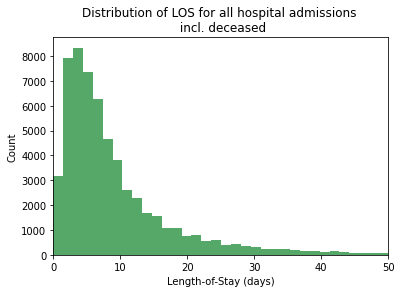

In [ ]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False)
plt.show();

In [ ]:
# Pre-emptively drop some columns that I don't need anymore
df.drop(columns=['DISCHTIME', 'ROW_ID',
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

In [ ]:
# Mark admissions where patients died in boolean column
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

In [ ]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(),
                                                     df['SUBJECT_ID'].nunique()))

5774 of 46445 patients died in the hospital


In [ ]:
# Look at statistics less admissions resulting in death
df['LOS'].loc[df['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

In [ ]:
# Hospital LOS metrics for later comparison
actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean()
actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median()

print(actual_mean_los)
print(actual_median_los)

10.138173704219758
6.565972222222222


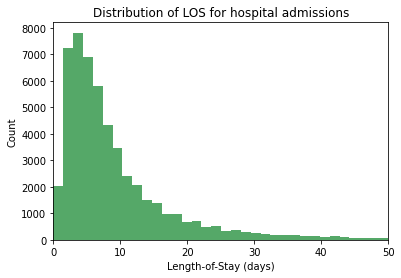

In [ ]:
plt.hist(df['LOS'].loc[df['DECEASED'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False)
plt.show();

In [ ]:
df['ETHNICITY'].value_counts()

WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

In [ ]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


WHITE                     41268
OTHER/UNKNOWN              7700
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
Name: ETHNICITY, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


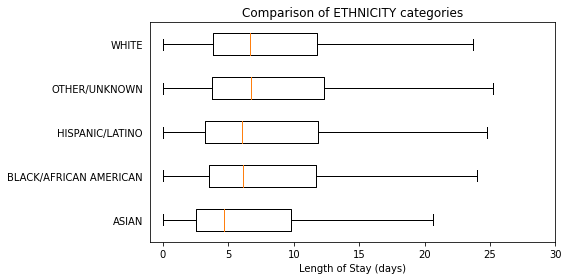

In [ ]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    '''
    Plot Median LOS by df categorical series name
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False)
    ax.set_title('Comparison of {} labels'.format(variable))

    plt.tight_layout()
    plt.show();

# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    '''
    Boxplot of LOS by df categorical series name
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False)
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

In [ ]:
df['RELIGION'].value_counts()

CATHOLIC                  20580
NOT SPECIFIED             11738
UNOBTAINABLE               8242
PROTESTANT QUAKER          7121
JEWISH                     5307
OTHER                      2695
EPISCOPALIAN                771
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


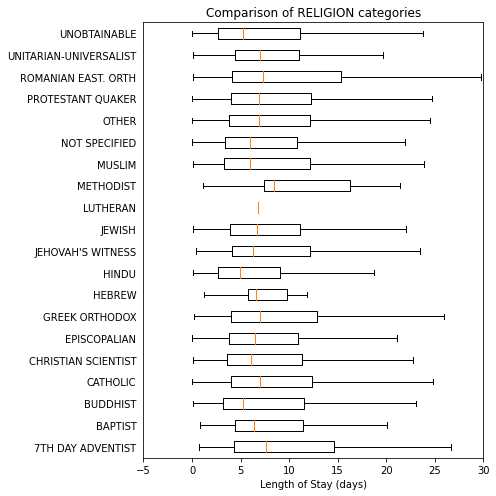

In [ ]:
boxplot_los_groupby('RELIGION', los_range=(-5, 30), size=(7, 7))

In [ ]:
# Reduce categories to terms of religious or not
# I tested with and without category reduction, with little change in R2 score
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())
print(df['RELIGION'].value_counts()[0]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[1]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[2]/len(df['RELIGION']))

RELIGIOUS        38898
NOT SPECIFIED    11738
UNOBTAINABLE      8242
Name: RELIGION, dtype: int64
0.6606542341791501
0.1993613913516084
0.13998437446924147


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


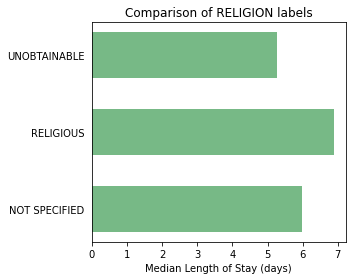

In [ ]:
# Look at median LOS for groups
plot_los_groupby('RELIGION', size=(5,4))

In [ ]:
df['ADMISSION_TYPE'].value_counts()

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


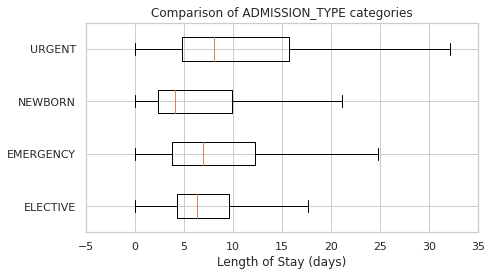

In [ ]:
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-5, 35), size=(7, 4))

In [ ]:
df['INSURANCE'].value_counts()

Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: INSURANCE, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


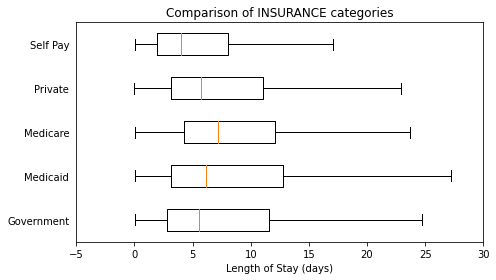

In [ ]:
boxplot_los_groupby('INSURANCE', los_range=(-5, 30), size=(7, 4))

In [ ]:
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
NaN                  10097
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [ ]:
# Fix NaNs and file under 'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

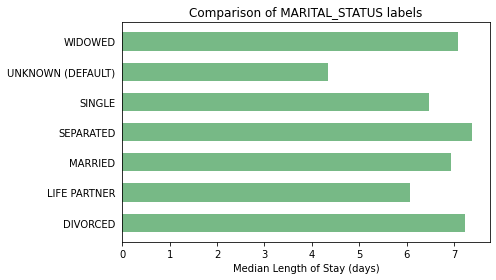

In [ ]:
plot_los_groupby('MARITAL_STATUS')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


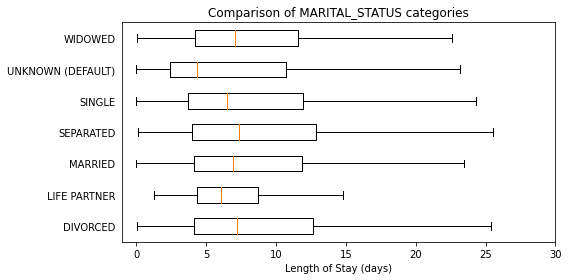

In [ ]:
boxplot_los_groupby('MARITAL_STATUS')

In [ ]:
df_diagcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [ ]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagcode['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


In [ ]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [ ]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [ ]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]),
            num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [ ]:
# Verify
df_diagcode.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,cat
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory


In [ ]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0], cat_range[1]),
                                     num, df_diagcode['recode'])

# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

# Verify
print(df_diagcode.head())

   ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  recode            cat
0    1297         109   172335      1.0     40301       6    circulatory
1    1298         109   172335      2.0       486       7    respiratory
2    1299         109   172335      3.0     58281       9  genitourinary
3    1300         109   172335      4.0      5855       9  genitourinary
4    1301         109   172335      5.0      4254       6    circulatory


In [ ]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [ ]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [ ]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [ ]:
# Merge with main admissions df
df = df.merge(hadm_item, how='inner', on='HADM_ID')

In [ ]:
# Verify Merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Comparison of Diagnoses')

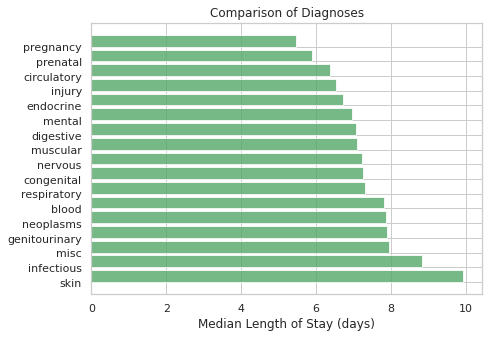

In [ ]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory',
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False)
ax.set_title('Comparison of Diagnoses'.format(variable))

In [ ]:
df_pat.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [ ]:
df_pat['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [ ]:
# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [ ]:
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [ ]:
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

In [ ]:
# Find the first admission time for each patient
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [ ]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [ ]:
# Verify merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,0,1,0,0,0,0,2131-05-07,F,2196-04-09 12:26:00
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,0,1,0,0,0,0,2082-07-17,M,2153-09-03 07:15:00
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,0,1,1,0,1,0,0,2082-07-17,M,2153-09-03 07:15:00
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2100-05-31,M,2139-06-06 16:14:00
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,2101-11-21,M,2160-11-02 02:06:00


In [ ]:
df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN']).dt.date
df['DOB'] = pd.to_datetime(df['DOB']).dt.date
df['age'] = df.apply(lambda e: (e['ADMIT_MIN'] - e['DOB']).days/365, axis=1)


# Convert timedelta type into float 'days', 86400 seconds in a day
#df['age'] = (df['ADMIT_MIN'] - df['DOB']).dt.total_days()//365
#df['age'] = df.apply(lambda e: (e['ADMIT_MIN'] - e['DOB']).days/365, axis=1)
#df['age'] = (df['ADMIT_MIN'].sub(df['DOB'], axis=0))// np.timedelta64(1, 'Y')
print(df.head())
#df['age'].isnull().sum

   SUBJECT_ID  HADM_ID           ADMITTIME DEATHTIME ADMISSION_TYPE  \
0          22   165315 2196-04-09 12:26:00       NaN      EMERGENCY   
1          23   152223 2153-09-03 07:15:00       NaN       ELECTIVE   
2          23   124321 2157-10-18 19:34:00       NaN      EMERGENCY   
3          24   161859 2139-06-06 16:14:00       NaN      EMERGENCY   
4          25   129635 2160-11-02 02:06:00       NaN      EMERGENCY   

          ADMISSION_LOCATION         DISCHARGE_LOCATION INSURANCE LANGUAGE  \
0       EMERGENCY ROOM ADMIT  DISC-TRAN CANCER/CHLDRN H   Private      NaN   
1  PHYS REFERRAL/NORMAL DELI           HOME HEALTH CARE  Medicare      NaN   
2  TRANSFER FROM HOSP/EXTRAM           HOME HEALTH CARE  Medicare     ENGL   
3  TRANSFER FROM HOSP/EXTRAM                       HOME   Private      NaN   
4       EMERGENCY ROOM ADMIT                       HOME   Private      NaN   

       RELIGION  ... neoplasms nervous pregnancy  prenatal  respiratory  skin  \
0  UNOBTAINABLE  ...   

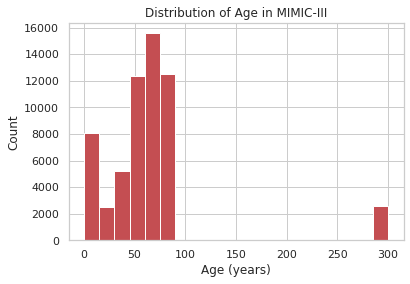

In [ ]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show();

(1.0, 50.0)

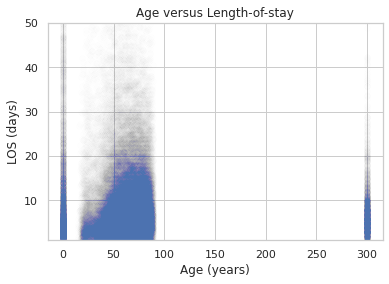

In [ ]:
plt.scatter(df['age'], df['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [ ]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]),
            num, df['age'])

age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

senior          32091
middle_adult    12077
newborn          8101
young_adult      3999
300.2            2610
Name: age, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


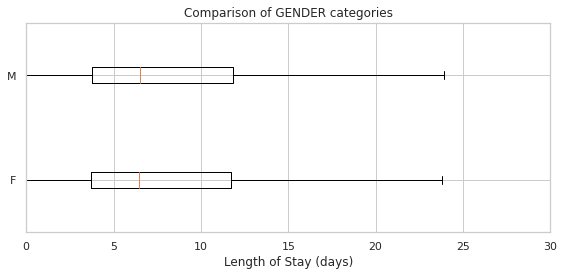

In [ ]:
boxplot_los_groupby('GENDER', los_range=(0, 30))
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

In [ ]:
# Intensive Care Unit (ICU) for each admission to hospital
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [ ]:
df_icu['HADM_ID'].nunique()

57786

In [ ]:
df_icu.groupby('FIRST_CAREUNIT').median()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
FIRST_CAREUNIT,,,,,,,
CCU,29091.5,22964.5,150074.5,249373.5,7.0,7.0,2.19775
CSRU,31002.5,24488.0,150225.0,250492.0,14.0,14.0,2.15290
MICU,33612.5,26489.5,150368.0,250524.0,50.0,50.0,2.09550
NICU,19581.5,15456.5,149206.5,249308.0,56.0,56.0,0.80250
SICU,38089.0,30084.0,149744.0,248649.0,33.0,33.0,2.25220
TSICU,36382.0,28716.0,148915.0,250685.0,14.0,14.0,2.11150


In [ ]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [ ]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [ ]:
df_icu['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [ ]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  


,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [ ]:

print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

Number of admissions to ICU 49794.
Number of admissions to NICU 7992.


In [ ]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='HADM_ID')

In [ ]:
# Replace NaNs with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)

In [ ]:

# Verify NaN fix
print(df.ICU.value_counts(dropna=False))
print(df.NICU.value_counts(dropna=False))

1.0    49794
0.0     9168
Name: ICU, dtype: int64
0.0    50970
1.0     7992
Name: NICU, dtype: int64


In [ ]:
# Look at what is no longer needed in the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58962 entries, 0 to 58961
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   SUBJECT_ID          58878 non-null  float64       
 1   HADM_ID             58962 non-null  int64         
 2   ADMITTIME           58878 non-null  datetime64[ns]
 3   DEATHTIME           5774 non-null   object        
 4   ADMISSION_TYPE      58878 non-null  object        
 5   ADMISSION_LOCATION  58878 non-null  object        
 6   DISCHARGE_LOCATION  58878 non-null  object        
 7   INSURANCE           58878 non-null  object        
 8   LANGUAGE            33606 non-null  object        
 9   RELIGION            58878 non-null  object        
 10  MARITAL_STATUS      58878 non-null  object        
 11  ETHNICITY           58878 non-null  object        
 12  DIAGNOSIS           58853 non-null  object        
 13  LOS                 58878 non-null  float64   

In [ ]:
# Remove deceased persons as they will skew LOS result
df = df[df['DECEASED'] == 0]

# Remove LOS with negative number, likely entry form error
df = df[df['LOS'] > 0]

In [ ]:
# Drop unused or no longer needed columns
df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58877
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ADMISSION_TYPE  53104 non-null  object 
 1   INSURANCE       53104 non-null  object 
 2   RELIGION        53104 non-null  object 
 3   MARITAL_STATUS  53104 non-null  object 
 4   ETHNICITY       53104 non-null  object 
 5   LOS             53104 non-null  float64
 6   blood           53104 non-null  float64
 7   circulatory     53104 non-null  float64
 8   congenital      53104 non-null  float64
 9   digestive       53104 non-null  float64
 10  endocrine       53104 non-null  float64
 11  genitourinary   53104 non-null  float64
 12  infectious      53104 non-null  float64
 13  injury          53104 non-null  float64
 14  mental          53104 non-null  float64
 15  misc            53104 non-null  float64
 16  muscular        53104 non-null  float64
 17  neoplasms       53104 non-null 

In [ ]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY','age', 'MARITAL_STATUS', 'RELIGION']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58877
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         53104 non-null  float64
 1   blood                       53104 non-null  float64
 2   circulatory                 53104 non-null  float64
 3   congenital                  53104 non-null  float64
 4   digestive                   53104 non-null  float64
 5   endocrine                   53104 non-null  float64
 6   genitourinary               53104 non-null  float64
 7   infectious                  53104 non-null  float64
 8   injury                      53104 non-null  float64
 9   mental                      53104 non-null  float64
 10  misc                        53104 non-null  float64
 11  muscular                    53104 non-null  float64
 12  neoplasms                   53104 non-null  float64
 13  nervous                     531

In [ ]:
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53104 entries, 0 to 58877
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         53104 non-null  float64
 1   blood                       53104 non-null  float64
 2   circulatory                 53104 non-null  float64
 3   congenital                  53104 non-null  float64
 4   digestive                   53104 non-null  float64
 5   endocrine                   53104 non-null  float64
 6   genitourinary               53104 non-null  float64
 7   infectious                  53104 non-null  float64
 8   injury                      53104 non-null  float64
 9   mental                      53104 non-null  float64
 10  misc                        53104 non-null  float64
 11  muscular                    53104 non-null  float64
 12  neoplasms                   53104 non-null  float64
 13  nervous                     531

In [ ]:
# Verify
df.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,RELIGION_NOT SPECIFIED,RELIGION_RELIGIOUS,RELIGION_UNOBTAINABLE
0,1.144444,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0,0,1,0,0,0,0,0,0,1
1,5.496528,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,6.768056,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,2.856944,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,3.534028,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
df.count()


LOS                           53104
blood                         53104
circulatory                   53104
congenital                    53104
digestive                     53104
endocrine                     53104
genitourinary                 53104
infectious                    53104
injury                        53104
mental                        53104
misc                          53104
muscular                      53104
neoplasms                     53104
nervous                       53104
pregnancy                     53104
prenatal                      53104
respiratory                   53104
skin                          53104
GENDER                        53104
ICU                           53104
NICU                          53104
ADM_ELECTIVE                  53104
ADM_EMERGENCY                 53104
ADM_NEWBORN                   53104
ADM_URGENT                    53104
INS_Government                53104
INS_Medicaid                  53104
INS_Medicare                

In [ ]:
# Target Variable (Length-of-Stay)
LOS = df['LOS'].values
# Prediction Features
features = df.drop(columns=['LOS'])

In [ ]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    LOS,
                                                    test_size = .20,
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 42483 samples.
Testing set has 10621 samples.


In [ ]:
#reg_model = GradientBoostingRegressor(random_state = 0)
#reg_model.fit(X_train, y_train)

#y_pred = reg_model.predict(X_test)
#mse = mean_squared_error(y_test,y_pred)
#print("MSE: %.2f" % mse)

#x_ax = range(len(y_test))
#plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
#plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
#plt.legend()
#plt.show()

#print("Model Accuracy: %.3f" % reg_model.score(X_test_std, y_test))
#y_test_preds = reg_model.predict(X_test)
#name = str(reg_model).split("(")

In [ ]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0),
          GradientBoostingRegressor(random_state = 0),
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:

    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


AttributeError: ignored

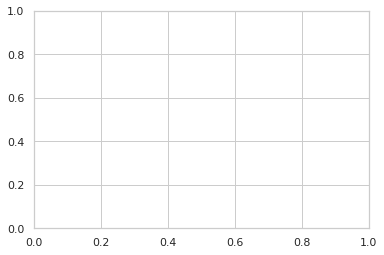

In [ ]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [ ]:
# GradientBoostingRegressor will be used as the LOS prediction model
reg_model = GradientBoostingRegressor(random_state=0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.360769


In [ ]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    LOS,
                                                    test_size = .20,
                                                    random_state = 42)

# Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [100, 200, 300],
#                     'max_depth' : [2, 3, 4],
#                     'loss': ['ls', 'lad', 'huber']}]
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['ls', 'lad']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in v

0.4101738792443411
GradientBoostingRegressor(loss='ls', max_depth=4, n_estimators=200)


In [ ]:
#reg_model = GradientBoostingRegressor(n_estimators = 200, max_depth=4, random_state=0)
#reg_model.fit(X_train, y_train)
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.385416


In [ ]:

print('Model refinement improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Model refinement improved R2 score by 0.0246


In [ ]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
prenatal,0.416420
respiratory,0.123676
nervous,0.092627
infectious,0.089420
digestive,0.064597
injury,0.037181
skin,0.023263
congenital,0.017084
genitourinary,0.015372
endocrine,0.013822


In [ ]:
feature_imp.index[0:10].tolist()

['prenatal',
 'respiratory',
 'nervous',
 'infectious',
 'digestive',
 'injury',
 'skin',
 'congenital',
 'genitourinary',
 'endocrine']

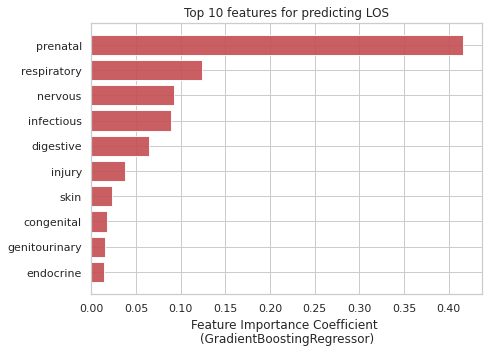

In [ ]:

# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10],
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False)
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
#fig.savefig('images/feature_importance.png', bbox_inches = 'tight')